# DNN

In [1]:
# !pip install torchmetrics

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# !pip install torchmetrics
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

In [4]:
df = pd.read_csv('./landslides_with_variables_cleaned.csv').drop(columns=['ID'])
df.head()

,Valid Landslide,Latitude,Longitude,CURVATURE,TWI,SLOPE_deg,DEM,ASPECT_deg,LANDCOVER_CODE,ASPECT_sin,ASPECT_cos
0,1,-36.819859,174.746298,1.379645,5.286413,11.441814,18.809872,222.978638,1.0,-0.681726,-0.731608
1,1,-36.798134,174.684934,0.190541,6.555068,14.671361,19.514647,166.090866,1.0,0.240383,-0.970678
2,1,-36.932751,174.744548,0.068507,9.921234,17.020342,22.542194,158.192902,11.0,0.371483,-0.928440
3,1,-36.852885,174.792092,0.528753,3.760681,29.180260,24.194622,59.103947,11.0,0.858100,0.513482
4,1,-36.809204,174.718141,-0.087607,5.854521,15.388130,69.367027,57.325916,1.0,0.841755,0.539860


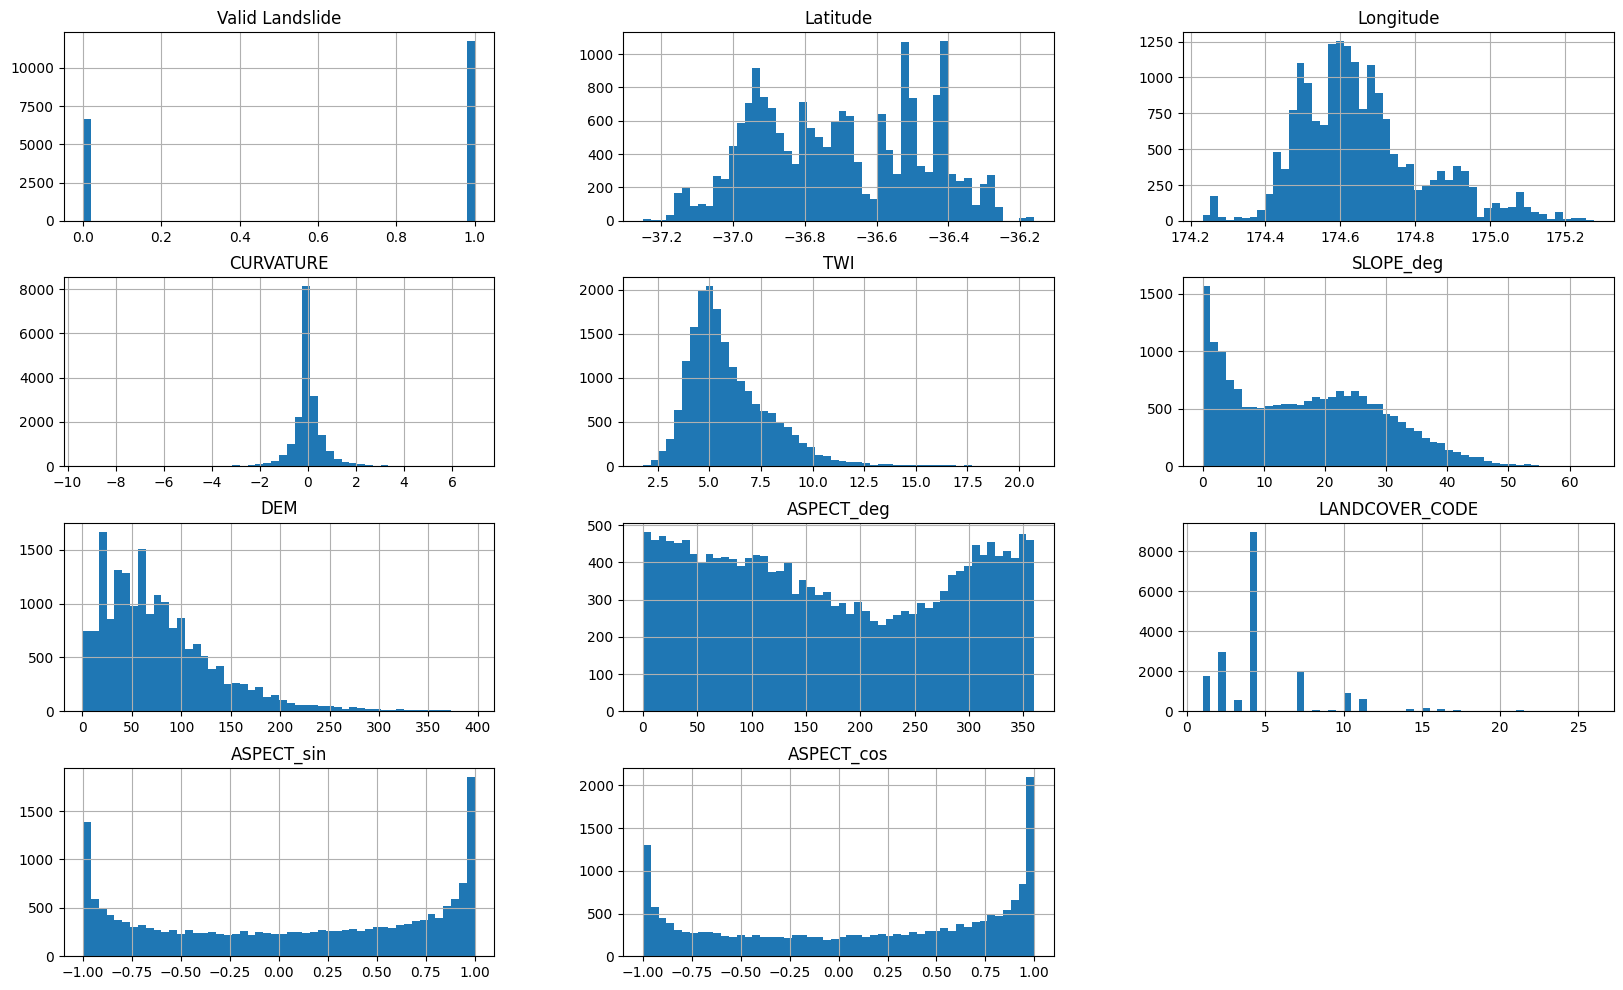

In [5]:
df.hist(bins=50, figsize=(20, 12))
plt.show()

## Spliting

In [6]:
# 1. Separate features (X) and target (y)
df['LANDCOVER_CODE'] = df['LANDCOVER_CODE'].astype(str)

X = df.drop(columns=["Valid Landslide", "Latitude", "Longitude"])
y = df["Valid Landslide"].copy()

# 2. Split data into training and testing sets
# 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=random_seed, stratify=y_train)


## Data Processing Pipeline

In [7]:
# Define pipelines
cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"))

num_pipeline = make_pipeline(
    StandardScaler())

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

set_config(display='diagram')
preprocessing

,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [8]:
X_train_prepared = preprocessing.fit_transform(X_train)
X_valid_prepared = preprocessing.transform(X_valid)
X_test_prepared = preprocessing.transform(X_test)

In [9]:
len(preprocessing.get_feature_names_out())

31

In [10]:
X_train_prepared.shape

(11053, 31)

In [11]:
preprocessing.get_feature_names_out()

array(['pipeline-1__CURVATURE', 'pipeline-1__TWI',
       'pipeline-1__SLOPE_deg', 'pipeline-1__DEM',
       'pipeline-1__ASPECT_deg', 'pipeline-1__ASPECT_sin',
       'pipeline-1__ASPECT_cos', 'pipeline-2__LANDCOVER_CODE_1.0',
       'pipeline-2__LANDCOVER_CODE_10.0',
       'pipeline-2__LANDCOVER_CODE_11.0',
       'pipeline-2__LANDCOVER_CODE_12.0',
       'pipeline-2__LANDCOVER_CODE_13.0',
       'pipeline-2__LANDCOVER_CODE_14.0',
       'pipeline-2__LANDCOVER_CODE_15.0',
       'pipeline-2__LANDCOVER_CODE_16.0',
       'pipeline-2__LANDCOVER_CODE_17.0',
       'pipeline-2__LANDCOVER_CODE_18.0',
       'pipeline-2__LANDCOVER_CODE_19.0',
       'pipeline-2__LANDCOVER_CODE_2.0',
       'pipeline-2__LANDCOVER_CODE_20.0',
       'pipeline-2__LANDCOVER_CODE_21.0',
       'pipeline-2__LANDCOVER_CODE_22.0',
       'pipeline-2__LANDCOVER_CODE_23.0',
       'pipeline-2__LANDCOVER_CODE_26.0',
       'pipeline-2__LANDCOVER_CODE_3.0', 'pipeline-2__LANDCOVER_CODE_4.0',
       'pipeline-2__LANDCO

In [12]:
X_train.index

Index([13825,   746,  7363, 10025, 15370,  9892, 17633,  5483,  9203,  4982,
       ...
       15439,  4748,  9066, 12030,  7984, 17230, 16931,  2999,  6542,  3112],
      dtype='int64', length=11053)

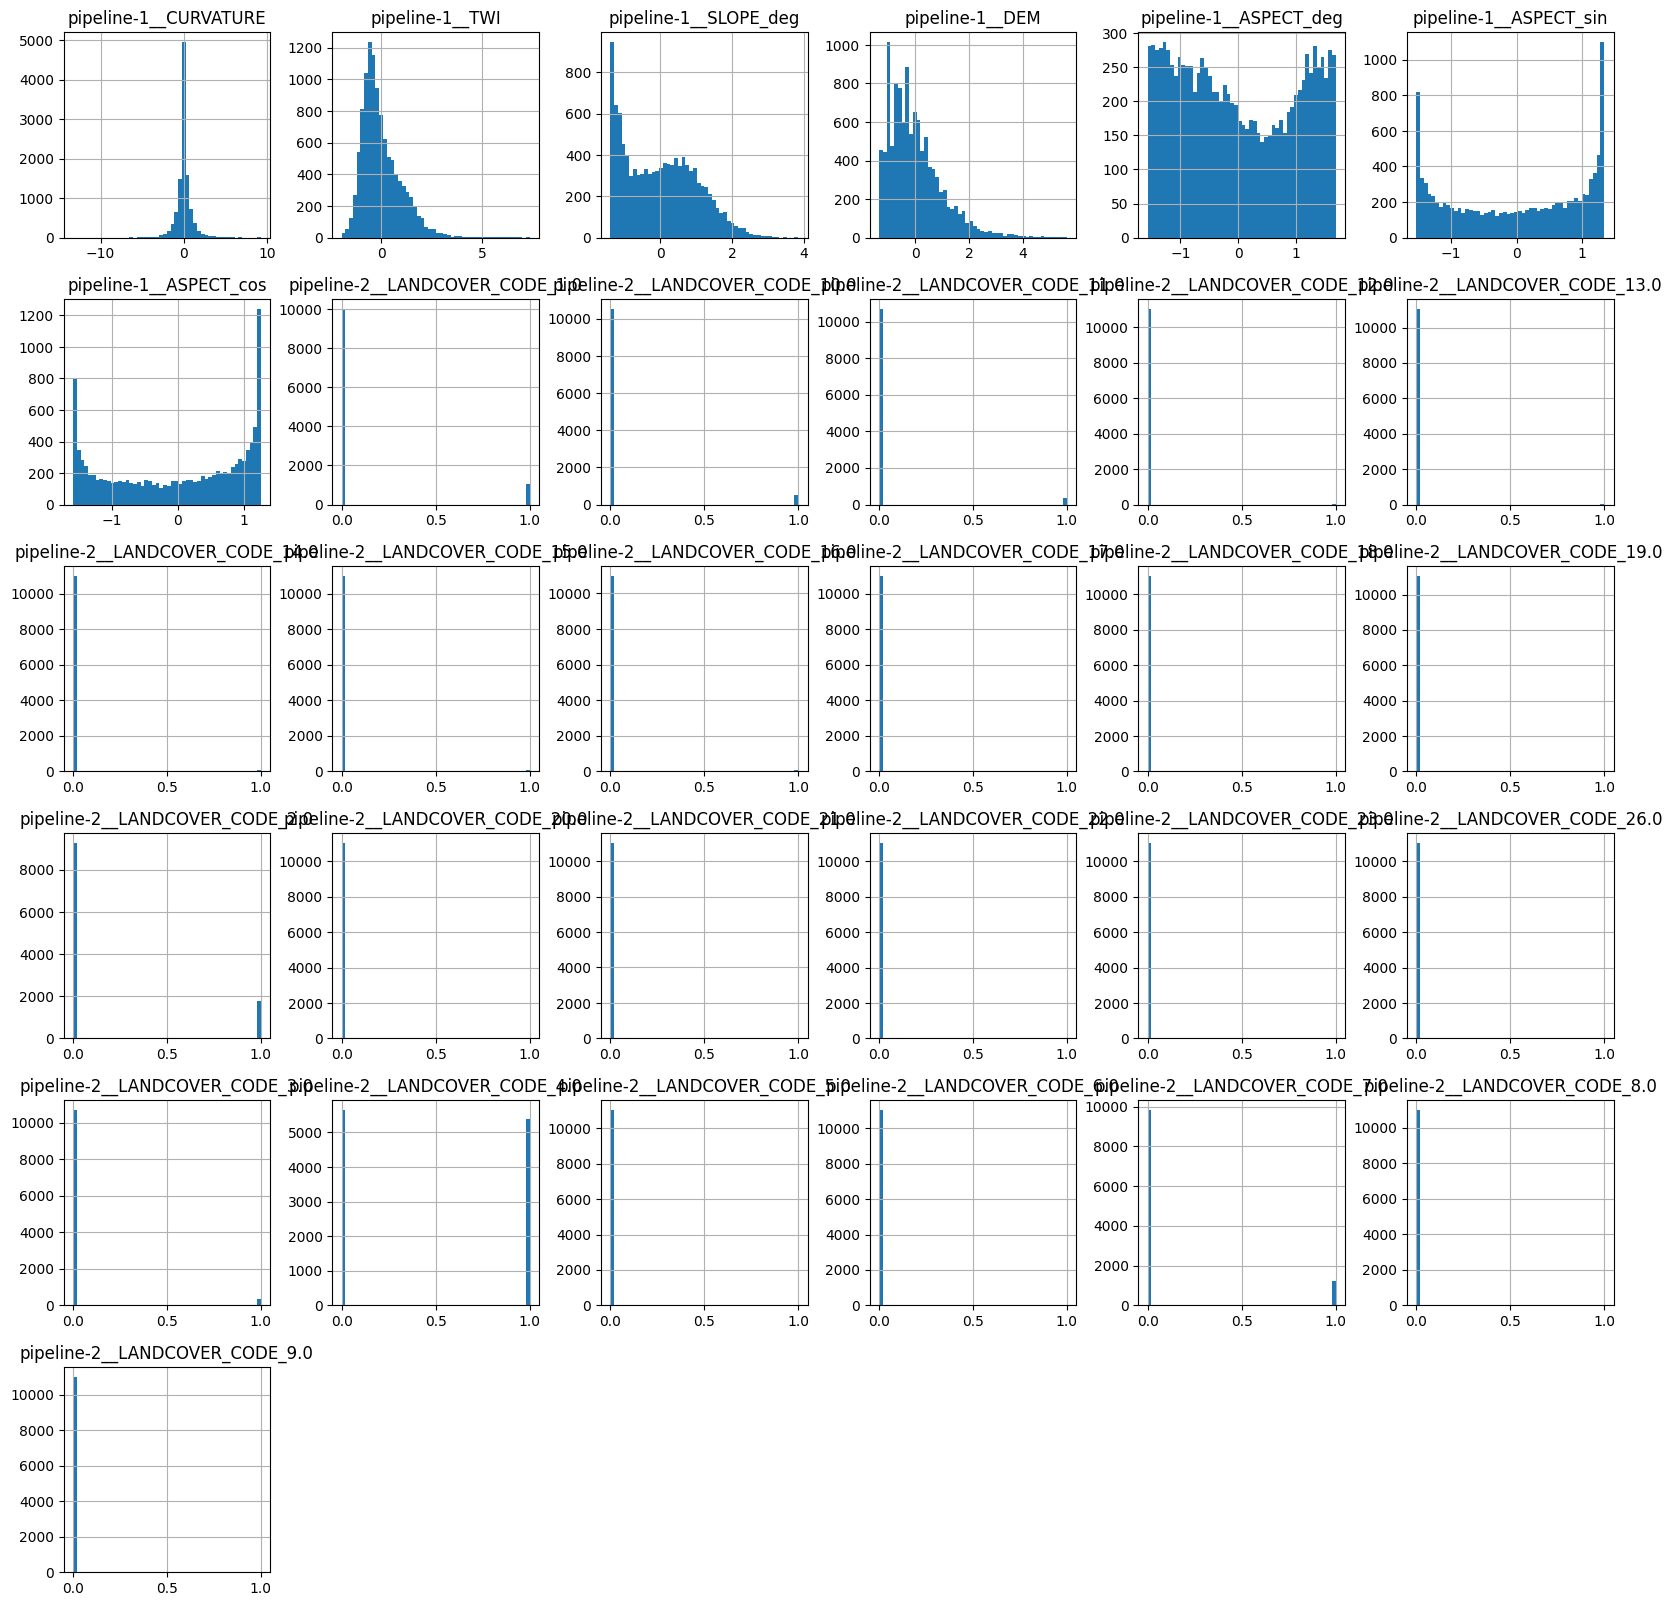

In [13]:
# (Optional) Display the transformed training data
df_prepared = pd.DataFrame(X_train_prepared.toarray(),
                           columns=preprocessing.get_feature_names_out(),
                           index=X_train.index)

df_prepared.hist(bins=50, figsize=(20, 20))
plt.show()

## Train the model

In [15]:
batch_size = 64

X_valid_tensor = torch.tensor(X_valid_prepared.toarray(), dtype=torch.float32) 
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)
X_train_tensor = torch.tensor(X_train_prepared.toarray(), dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_prepared.toarray(), dtype=torch.float32) 
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Now create the TensorDataset with the correct data types
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
def train(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        #Training
        model.train()
        epoch_train_loss = 0.
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            y_train_batch = y_train_batch.float().unsqueeze(1)
            y_train_pred = model(X_train_batch)
            train_loss = loss_fn(y_train_pred, y_train_batch)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        mean_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(mean_epoch_train_loss)

        # Validation
        model.eval()
        epoch_valid_loss = 0.
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                y_valid_batch = y_valid_batch.float().unsqueeze(1)
                y_valid_pred = model(X_valid_batch)
                valid_loss = loss_fn(y_valid_pred, y_valid_batch)
                epoch_valid_loss += valid_loss.item()
        mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        valid_losses.append(mean_epoch_valid_loss)

        print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")

    return (train_losses, valid_losses)

In [17]:
def set_model():
  n_attributes = X_valid_tensor.shape[1]
  n_outputs = 1
  model = nn.Sequential(
  nn.Linear(n_attributes, 50),
  nn.ReLU(),
  nn.Linear(50, 40),
  nn.ReLU(),
  nn.Linear(40, n_outputs)
  )
  return model

model = set_model().to(device)

In [18]:
model = set_model().to(device)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss = nn.BCEWithLogitsLoss()
n_epochs = 50

In [19]:
train_losses, valid_losses = train(
    model, optimizer, loss, train_loader, valid_loader, n_epochs)

Epoch 1/50, Training Loss: 0.6545, Valid Loss: 0.6251
Epoch 2/50, Training Loss: 0.5934, Valid Loss: 0.5633
Epoch 3/50, Training Loss: 0.5238, Valid Loss: 0.4953
Epoch 4/50, Training Loss: 0.4578, Valid Loss: 0.4434
Epoch 5/50, Training Loss: 0.4160, Valid Loss: 0.4182
Epoch 6/50, Training Loss: 0.3952, Valid Loss: 0.4038
Epoch 7/50, Training Loss: 0.3837, Valid Loss: 0.3953
Epoch 8/50, Training Loss: 0.3760, Valid Loss: 0.3869
Epoch 9/50, Training Loss: 0.3696, Valid Loss: 0.3805
Epoch 10/50, Training Loss: 0.3643, Valid Loss: 0.3742
Epoch 11/50, Training Loss: 0.3600, Valid Loss: 0.3676
Epoch 12/50, Training Loss: 0.3567, Valid Loss: 0.3640
Epoch 13/50, Training Loss: 0.3540, Valid Loss: 0.3615
Epoch 14/50, Training Loss: 0.3521, Valid Loss: 0.3582
Epoch 15/50, Training Loss: 0.3501, Valid Loss: 0.3562
Epoch 16/50, Training Loss: 0.3488, Valid Loss: 0.3533
Epoch 17/50, Training Loss: 0.3476, Valid Loss: 0.3540
Epoch 18/50, Training Loss: 0.3468, Valid Loss: 0.3511
Epoch 19/50, Traini

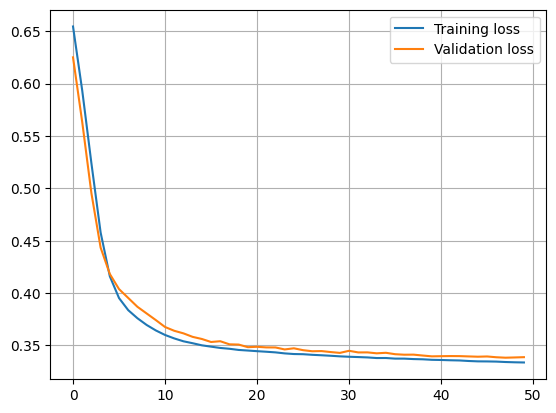

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.grid()
plt.legend()

In [21]:
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            # Get the raw model outputs (logits)
            test_outputs = model(X_test_batch)
            
            # Apply sigmoid to get probabilities and then round to get predictions
            predicted = torch.round(torch.sigmoid(test_outputs))
            
            total += y_test_batch.size(0)
            correct += (predicted.squeeze() == y_test_batch).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy

In [22]:
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 85.18%


## Susceptibility prediction

In [27]:
def risk_assessment(model, data_loader, device):
    """
    Evaluates the model on the data loader and returns a list of risk assessments.
    """
    model.eval()  # Set the model to evaluation mode
    all_scores = []
    all_assessments = []
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            
            # 1. Get the raw model outputs (logits)
            outputs = model(X_batch)
            
            # 2. Apply sigmoid to get probabilities (the 'score')
            scores = torch.sigmoid(outputs).cpu().numpy().flatten()
            
            # 3. Categorize the risk for each score in the batch
            for score in scores:
                if score < 0.2:
                    assessment = "Very Low risk"
                elif score < 0.4:
                    assessment = "Low risk"
                elif score < 0.6:
                    assessment = "Moderate risk"
                elif score < 0.8:
                    assessment = "High risk"
                else:
                    assessment = "Very High risk"
                all_assessments.append(assessment)

            all_scores.extend(scores)

    # Create a DataFrame for easy analysis
    results_df = pd.DataFrame({
        'Predicted_Score': all_scores,
        'Risk_Assessment': all_assessments
    })
            
    return results_df

In [28]:
reals = pd.DataFrame({
    #                [Area 1, Area 2]
    'CURVATURE':     [1.5, 0.1],
    'TWI':           [4.8, 8.0],
    'SLOPE_deg':     [25.0, 5.0],
    'DEM':           [50.0, 120.0],
    'LANDCOVER_CODE':['4', '1'],
    'ASPECT_deg':    [130.0, 210.0],
    'ASPECT_sin':    [0.766, 0.5],
    'ASPECT_cos':    [-0.643, -0.866],
})

# Use the *fitted* preprocessing pipeline to transform the new data
# Do NOT call .fit_transform() again!
reals_prepared = preprocessing.transform(reals)

# Convert the processed data to a PyTorch tensor
reals_tensor = torch.tensor(reals_prepared.toarray(), dtype=torch.float32)

# Create a dummy labels tensor (it won't be used for prediction, but is needed for the DataLoader)
dummy_labels = torch.zeros(reals_tensor.shape[0], dtype=torch.long)

# Create a DataLoader for the new data
reals_dataset = TensorDataset(reals_tensor, dummy_labels)
reals_loader = DataLoader(reals_dataset, batch_size=2)

In [29]:
# Use the trained model and the new data loader to get risk assessments
real_world_assessments = risk_assessment(model, reals_loader, device)

print("\n--- Landslide Risk Assessment Results ---")
print(real_world_assessments)


--- Landslide Risk Assessment Results ---
   Predicted_Score Risk_Assessment
0         0.869878  Very High risk
1         0.210779        Low risk
